(c)

In [ ]:
!pip install scikit-learn scikit-image

In [1]:
from sklearn . datasets import fetch_openml
from sklearn . model_selection import train_test_split
import numpy as np
import cv2

ds = fetch_openml('mnist_784', as_frame = False)

x, x_test, y, y_test = train_test_split(ds.data,ds.target,test_size =0.2,random_state =42)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
resize_x = []
resize_x_test = []

# Resize training dataset
for row in x:
    resized = cv2.resize(row.reshape((28 ,28)), (14,14))
    resize_x.append(resized)

# Resize testing dataset
for row in x_test:
    resized = cv2.resize(row.reshape((28 ,28)), (14,14))
    resize_x_test.append(resized)

# Convert back to NumPy arrays
x= np.array(resize_x).reshape(56000, 196)
x_test = np.array(resize_x_test).reshape(14000, 196)
y = y.astype(int)
y_test = y_test.astype(int)

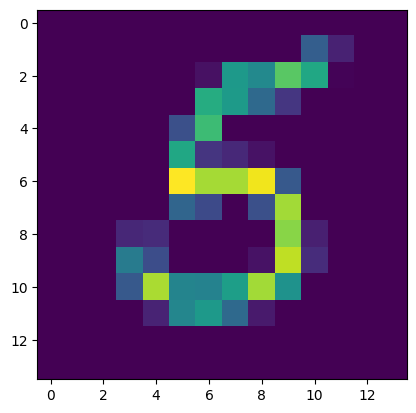

In [3]:
import matplotlib.pyplot as plt
a = x[0]. reshape ((14 ,14))
plt. imshow (a)

In [4]:
# combine data x and y column wise
combined = np.column_stack((x,y))
data = []

for i in range(10):
  # find digit data based on label
  tmp = combined[np.where(combined[:,-1]==i)]

  # select 1000 samples from one digit data
  indices = np.random.choice(len(tmp), 1000, replace = False)
  data.append(tmp[indices,:])


In [5]:
from sklearn.preprocessing import MinMaxScaler

# flatten matrix by ungrouping data
data = np.array(data).reshape(10000,197)
np.random.shuffle(data)

# min max normalization, all data in range (0,1) now
scaler = MinMaxScaler()
smodel = scaler.fit(data[:,:-1])
x_data= smodel.transform(data[:,:-1])
y_data = data[:,-1]
smodel_test = scaler.fit(x_test)
x_test = smodel_test.transform(x_test)

# split train and validation dataset
x_train, x_val, y_train, y_val = train_test_split(x_data,y_data,test_size =0.2,random_state = 42)

(d)

In [6]:
from sklearn import svm

# model building
classifier = svm.SVC(C=1.0, kernel ='rbf', gamma ='auto')

# model training
classifier.fit(x_train, y_train)

# model prediction - x_val
y_pre = classifier.predict(x_val)

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# validation error for y_val
print("validation error is: {:.4f}%\n".format((1-accuracy_score(y_val, y_pre))*100))

# support sample ratio for the classifier
print("support sample ratio is: {:.4f}%\n".format(classifier.n_support_.sum()/x_train.shape[0]*100))

validation error is: 7.8500%

support sample ratio is: 58.8500%



In [8]:
# run classifier on x_test
y_test_pre = classifier.predict(x_test)

In [9]:
# classification error for y_test
print("classification error is: {:.4f}%\n".format((1-accuracy_score(y_test, y_test_pre))*100))

classification error is: 8.7714%



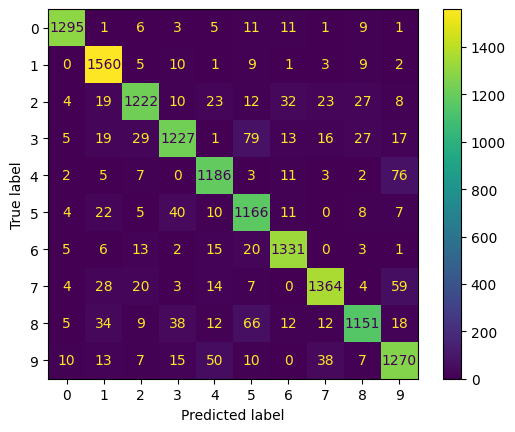

In [10]:
# confusion matrix for y_test
confusion = confusion_matrix(y_test,y_test_pre)
disp = ConfusionMatrixDisplay(confusion)
disp.plot()
plt.show()

(g)

In [11]:
from sklearn.model_selection import GridSearchCV
svc = svm.SVC(kernel='rbf',gamma='auto')

# possible parameter values
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# grid search training
grid = GridSearchCV(svc, params, scoring='accuracy')
grid.fit(x_train, y_train)

GridSearchCV(estimator=SVC(gamma='auto'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='accuracy')

In [12]:
# mean test score for each hyperparameter
grid.cv_results_['mean_test_score']*100

array([10.35  , 10.35  , 81.725 , 90.2875, 92.975 , 93.875 , 94.2125])

In [13]:
# the best C
best_C = grid.best_params_['C']
best_accuracy = grid.best_score_
print("Best C:", best_C, " Best Mean Accuracy:", round(best_accuracy,4)*100,"%")

Best C: 1000  Best Mean Accuracy: 94.21000000000001 %


(h)

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# select 100 training sample and 100 test sample
# combine data x and y column wise
train = []
val = []
for i in range(10):
  # find digit data based on label
  tmp = combined[np.where(combined[:,-1]==i)]
  # select 200 samples from one digit data
  indices = np.random.choice(len(tmp), 200, replace = False)
  class_samp = tmp[indices,:]
  train.append(class_samp[:100,:])
  val.append(class_samp[100:,:])

train = np.array(train).reshape(1000,197)
val = np.array(val).reshape(1000,197)
np.random.shuffle(train)
np.random.shuffle(val)
x_tr, y_tr = train[:,:-1], train[:,-1]
x_vl, y_vl = val[:,:-1], val[:,-1]

scaler = MinMaxScaler()
x_tr = scaler.fit_transform(x_tr)
x_vl = scaler.transform(x_vl)

(j)

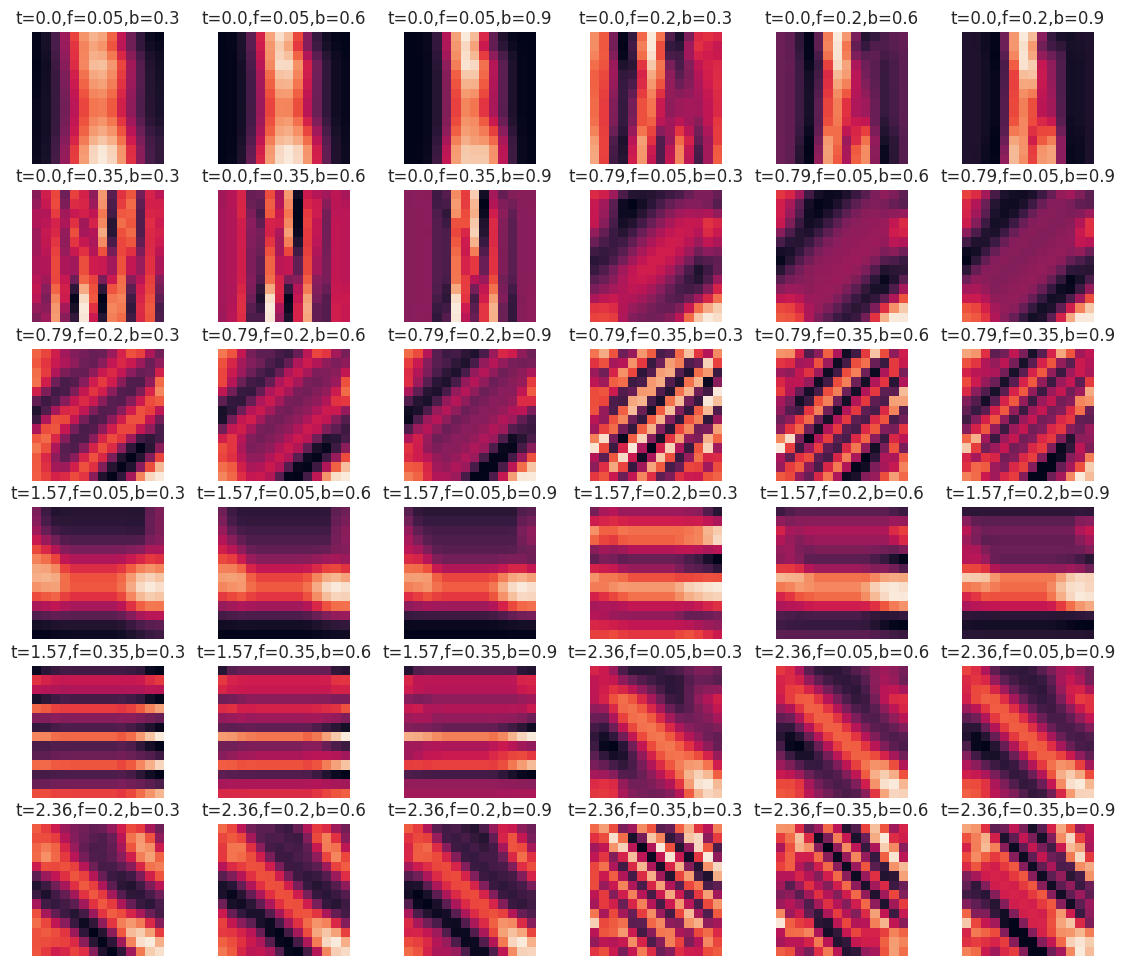

In [81]:
# extract features
def extract_gabor_bank(img, theta, freq, bandw):
  kernel = cv2.getGaborKernel((15, 15), sigma=1/bandw, theta = theta, lambd=1/freq, gamma=0, psi=0, ktype=cv2.CV_32F)
  feature = cv2.filter2D(img, cv2.CV_32F, kernel)
  return feature

# sample image gabor filter bank visualization
image = x_tr[0].reshape((14 ,14))
theta = np.arange(0, np.pi, np.pi/4)
frequency = np.arange(0.05, 0.5, 0.15)
bandwidth = np.arange(0.3, 1, 0.3)
i = 0
j = 0
fig, axes = plt.subplots(6, 6, figsize=(14, 12))
for t in theta:
  for f in frequency:
    for b in bandwidth:
      features = extract_gabor_bank(image, t, f, b)
      ax = axes[i, j]
      ax.set_title("t={0},f={1},b={2}".format(round(t,2),round(f,2),round(b,2)))
      ax.axis('off')
      ax.imshow(features)
      i = i+1 if j==5  else i
      j = 0 if j==5 else j+1
plt.show()

In [82]:
# build gabor filter bank matrix
gabor_train = []
gabor_val = []
theta = np.arange(0, np.pi, np.pi/4)
frequency = np.arange(0.05, 0.5, 0.15)
bandwidth = np.arange(0.3, 1, 0.3)
train_image = x_tr.reshape((1000,14,14))
val_image = x_vl.reshape((1000,14,14))
for i in range(len(x_tr)):
  n = 0
  for t in theta:
    for f in frequency:
      for b in bandwidth:
        n += 1
        gabor_train.append(extract_gabor_bank(train_image[i], t, f, b))
        gabor_val.append(extract_gabor_bank(val_image[i], t, f, b))


In [83]:
# reformat data so that each data point have shape (1,7056)
gabor_train = np.array(gabor_train).reshape(1000,196*n)
gabor_val = np.array(gabor_val).reshape(1000,196*n)

In [84]:
# normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gabor_train = scaler.fit_transform(gabor_train)
gabor_val = scaler.transform(gabor_val)

In [85]:
classifier = svm.SVC(C=100, kernel ='rbf', gamma ='auto')
classifier.fit(gabor_train,y_tr)

SVC(C=100, gamma='auto')

In [86]:
print("training score is: {:.4f}%\n".format(classifier.score(gabor_train, y_tr)*100))

training score is: 100.0000%



In [87]:
y_vl_pre = classifier.predict(gabor_val)
print("validation score is: {:.4f}%\n".format(accuracy_score(y_vl, y_vl_pre)*100))

validation score is: 89.1000%



In [88]:
from sklearn.decomposition import PCA

# increase filter sizes
gabor_train = []
gabor_val = []
theta = np.arange(0, np.pi, np.pi/4)
frequency = np.arange(0.05, 1, 0.15)
bandwidth = np.arange(0.3, 2, 0.3)
for i in range(len(x_tr)):
  n = 0
  for t in theta:
    for f in frequency:
      for b in bandwidth:
        n += 1
        gabor_train.append(extract_gabor_bank(train_image[i], t, f, b))
        gabor_val.append(extract_gabor_bank(val_image[i], t, f, b))

# reformat data so that each data point have shape (1,196*n)
gabor_train = np.array(gabor_train).reshape(1000,196*n)
gabor_val = np.array(gabor_val).reshape(1000,196*n)

# normalize data
scaler = StandardScaler()
scaler.fit(gabor_train)
gabor_train = scaler.transform(gabor_train)
gabor_val = scaler.transform(gabor_val)

# apply PCA
pca = PCA()
gabor_train = pca.fit_transform(gabor_train)
gabor_val = pca.transform(gabor_val)

classifier = svm.SVC(C=100, kernel ='rbf', gamma ='auto')
classifier.fit(gabor_train,y_tr)

print("training score is: {:.4f}%\n".format(classifier.score(gabor_train, y_tr)*100))

y_vl_pre = classifier.predict(gabor_val)
print("validation score is: {:.4f}%\n".format(accuracy_score(y_vl, y_vl_pre)*100))

training score is: 100.0000%

validation score is: 29.5000%

